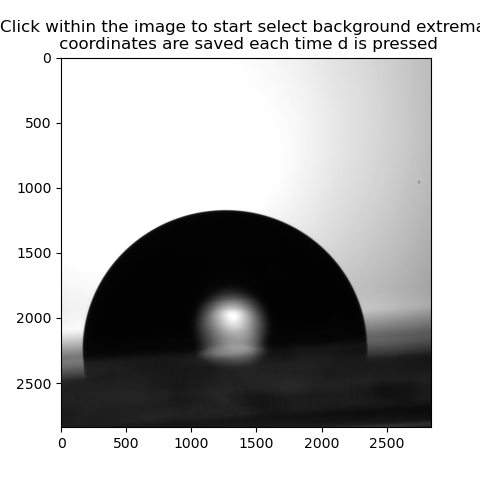

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import scipy as sci
import csv

%matplotlib ipympl

# load the image
plt.rcParams['image.cmap'] = 'gray'
#img_raw = ski.io.imread('Image__2023-06-05__11-12-38.bmp')
#img_raw = ski.io.imread('ang30_800.png')
img_raw = ski.io.imread('group2_pre_plasma.png')
# convert it to grayscale
if img_raw.ndim > 2:
    img = ski.color.rgb2gray(img_raw[:,:,0:3])
else:
    img =img_raw

# function to measure the coordinates of the contact points
coords=[]
def on_key(event):
    if event.key == 'd':
        x1, y1 =event.xdata, event.ydata
        coords.append([x1, y1])
        fig.canvas.draw()
        return coords

# interactive figure
fig1, axf =plt.subplots(1,1, figsize=plt.figaspect(img))
cid = fig1.canvas.mpl_connect('key_press_event', on_key)
plt.imshow(img)#, cmap='gray', vmin=0, vmax=255)
tl = axf.set_title('Click within the image to start select background extrema \n coordinates are saved each time ''d'' is pressed')
plt.show()

In [2]:
coords=[[176.1408683567356, 2326.5388651938465],[2357.1443667034073, 2234.6713231418025]] # group2 drop

In [3]:
# disconenct the ipympl figure 
fig1.canvas.mpl_disconnect(cid)
plt.close() #this to avoid opening tens of figures

##coords=[[134.93200806519178, 1231.2330966390532],[2360.6332699742647, 1079.7907884373694]]
##ang30_400.png
#coords=[[144.8800062840386, 170.96585796763713], [253.91229364133852, 171.0053556045768]]
##ang30_800.png
#coords=[[290.9508819580078, 343.0033311059464], [507.98306157001383, 343.0218480901313]]
##ang30_2000.png
#coords=[[729.0909217177835, 857.0564771981342], [1269.9916371553527, 856.9859494134936]]
##ang120_400.png
#coords=[[113.09817255577084, 170.93840594888977], [285.96683205907004, 170.8389757671763]]
##ang120_800.png
#coords=[[225.97013148188077, 342.05047752743667], [572.9650321044397, 341.99110781772004]]
##ang120_2000.png
#coords=[[565.9992980295474, 857.0008658697703], [1433.034212822059, 856.9876711696602]]
##ang90_400.png
#coords=[[100.03702448904784, 171.06911517090336], [299.04631782747003, 170.9812947717402]]
##ang90_800.png
#coords=[[200.00056026539264, 342.15113430659784],[598.9514551009904, 341.9856407940084]]
##ang90_2000.png
#coords=[[499.9302565304077, 856.9899821763846], [1499.0557209695191, 857.0204095447581]]
print(coords)

[[176.1408683567356, 2326.5388651938465], [2357.1443667034073, 2234.6713231418025]]


In [4]:
# find the angle of inclination of the figure
xv = coords[1][0] - coords[0][0]
yv = coords[1][1] - coords[0][1]
m = np.arctan(yv / xv)

# rotate the image using the left contact point as pivot and cut the bottom part of the image
mod_img = ski.transform.rotate(img, m*360/(2*np.pi), center=coords[0])[0:int(coords[0][1]),0:-1]

# convert to BW
thresh = ski.filters.threshold_otsu(mod_img)
bw = mod_img < 0.3

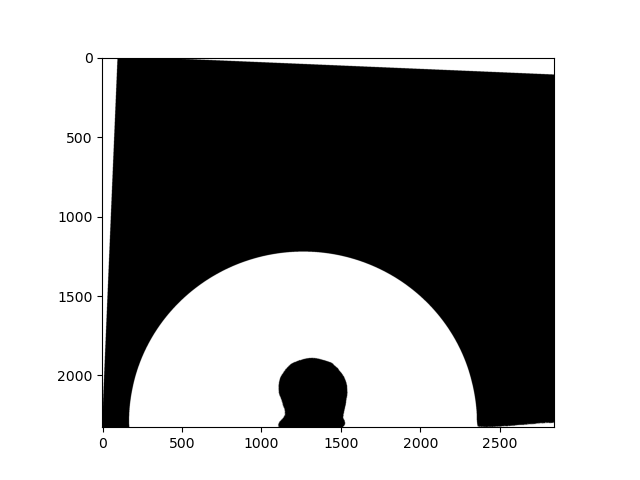

In [5]:
# manual check of threshold 
plt.close()
#plt.imshow(mod_img<0.3) # modify this parameter to find the optimal threshold
plt.imshow(bw)
plt.show()

In [7]:
# add an empty line to the last image line BEFORE clearing ojects that touch image borders
bw2 = np.append(bw,np.zeros((1,bw.shape[1])),axis=0)
# Clear objects connected to the image border
# this is a measure just to be sure there's nothing touching the image edges,
# we sohuld also check there are no other objects (eg dark spots) that might interfere with the image analysis 
cleared = ski.segmentation.clear_border(bw2)
# remove added line (since the drop is detached from the edge, it cannot be removed by the previous fitlering), so we can remove the line previuosly added
bw = cleared[:-1,:]

#remove foreign small objects
bw = ski.morphology.opening(bw, ski.morphology.disk(5))
# skeltonize to reduce line to single pixel width. EDGES is a boolean dtype
edges = ski.morphology.skeletonize(ski.feature.canny(bw))
edges = edges[:-1,:] # -1 to remove last empty line

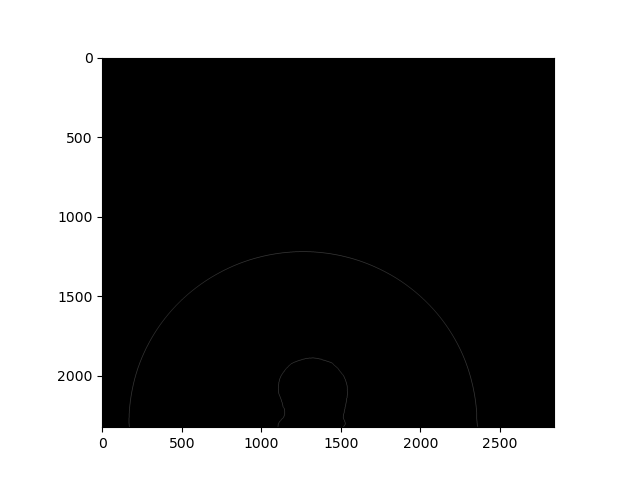

In [14]:
plt.close()
plt.imshow(edges)
plt.show()

In [8]:
label_img= ski.morphology.label(bw)

In [12]:
labels=ski.measure.regionprops(label_img)

In [13]:
len(labels)

1

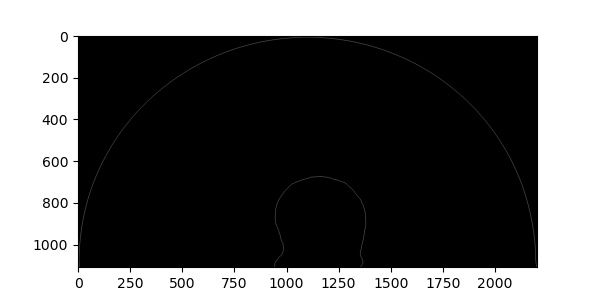

In [15]:
# padding set the border to clearly visualize the entire drop shape
padding = 5
# +1 required to avoid skipping the last line
edges_cropped = edges[ np.min(edges.nonzero()[0])-padding : np.max(edges.nonzero()[0]+1) , np.min(edges.nonzero()[1])-padding : np.max(edges.nonzero()[1])+1+padding ]
edges= edges_cropped

if edges.shape[0] < 100:
    print('WARNING! Low image resolution')
    
plt.figure(figsize=(6,3))
plt.imshow(edges)
plt.show()

In [16]:
# remove central white spot due to LED imaged through the drop
edges[600:,700:1600]=0

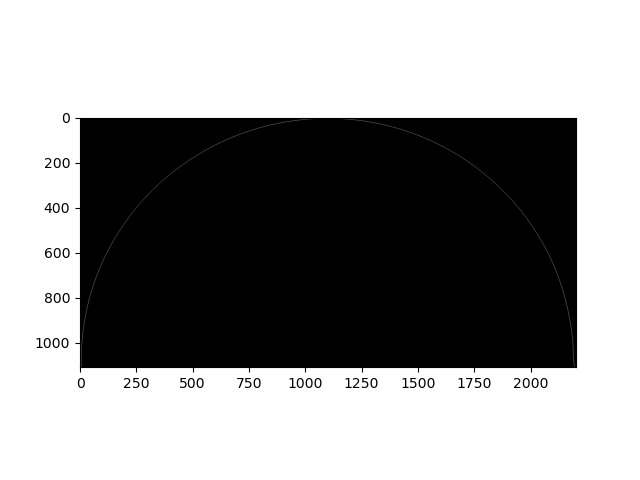

In [19]:
plt.close()
plt.imshow(edges)
plt.show()

Rotate image


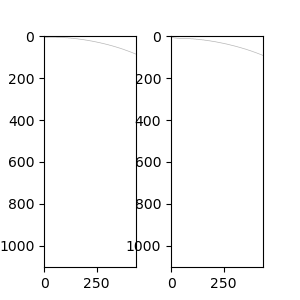

In [21]:
plt.close()

# return index of the bottom left pixels of the drop edge
# find the "raw" derivative of the first pixel_range lines to determine if CA > 45°.
# if CA > 45° image is rotated 90° clockwise

# use only a fraction of the image lines to estimate the edge derivative and to choose IF rotate the image
pixel_range = int(0.1*edges.shape[0]) 

# fraction of horizontal lines to keep to fit with spline
pixels_to_keep = .2 #0.2

# np.nonzero return the indexes of the nonzero elements of the left part of the drop
init_drop_profile = np.asarray(np.nonzero(edges[-pixel_range:,:int(edges.shape[1]/2)]))
dy = np.max(init_drop_profile[1,:])-np.min(init_drop_profile[1,:])
dx = np.max(init_drop_profile[0,:])-np.min(init_drop_profile[0,:])
ang = dx/dy # dx is along the VERTICAL axis

# if  CA > 90° then the profile is no more a unique function, then 45° has been arbitrarly chosen as threshold to rotate the figure
if ang > 1:
    rotate = 1
    # notify the user that the image has been rotated
    print('Rotate image')
    # multipliers at the end of the lines is: 0.5: keep half image
    edges_left = np.rot90(edges[:,0:int(np.round(edges.shape[1]*0.5))], k=1, axes=(1,0))[:,0:int(edges.shape[1]*pixels_to_keep)]
    edges_right = np.fliplr(np.rot90(edges[:,-int(np.round(edges.shape[1]*0.5)):], k=-1, axes=(1,0)))[:,0:int(edges.shape[1]*pixels_to_keep)]

#                                             keep L/R part of the image       rotation verse         keep only selected lines             
#               edges_left = np.rot90(edges[:,0:int(np.round(edges.shape[1]*0.5))], k=1, axes=(1,0))[:,0:int(edges.shape[1]*.5*pixels_to_keep)]
#    edges_right = np.fliplr(np.rot90(edges[:,-int(np.round(edges.shape[1]*0.5)):], k=-1, axes=(1,0)))[:,0:int(edges.shape[1]*.5*pixels_to_keep)]    

# check the effects of the part fo the previuos lines in a new cell
#plt.close()
#plt.imshow(np.rot90(edges[:,0:int(np.round(edges.shape[1]*0.5))]))
#plt.imshow(np.fliplr(np.rot90(edges[:,-int(np.round(edges.shape[1]*0.5)):], k=-1, axes=(1,0))))
#plt.show()

    #if the length of the edges is less than 50 pixels, then keep the entire edge
    if edges_left.shape[1] < 50:
        edges_left = np.rot90(edges[:,0:int(np.round(edges.shape[1]*0.5))], k=1, axes=(1,0))[:,0:50]
        edges_right = np.fliplr(np.rot90(edges[:,-int(np.round(edges.shape[1]*0.5)):], k=-1, axes=(1,0)))[:,0:50]
else:
    rotate = 0
    edges_left = edges[:,0:int(np.round(edges.shape[1]*0.5))]
    edges_right = np.fliplr(edges[:,-int(np.round(edges.shape[1]*0.5)):])
    if edges_left.shape[1] < 50:
        edges_left = np.rot90(edges[:,0:int(np.round(edges.shape[1]*0.5))], k=1, axes=(1,0))[:,0:50]
        edges_right = np.fliplr(np.rot90(edges[:,-int(np.round(edges.shape[1]*0.5)):], k=-1, axes=(1,0)))[:,0:50]

fig3, (ax31, ax32) = plt.subplots(1,2, figsize=(3,3))
ax31.imshow(np.logical_not(edges_left))
ax32.imshow(np.logical_not(edges_right))
plt.show()

In [22]:
plt.close()

# coordinates of the pixels composing the edge
left_EC = np.array(np.where(edges_left[:,:]==1)).T
right_EC = np.array(np.where(edges_right[:,:]==1)).T

#
ord_left_EC = left_EC[left_EC[:,1].argsort()]
ord_right_EC = right_EC[right_EC[:,1].argsort()]

In [ ]:
plt.close()
plt.plot(left_EC[:,0],left_EC[:,1],'r.')
plt.show()
print(left_EC[0:20,:])
print(ord_left_EC[0:20,:])

In [30]:
# select which side of the drop to fit
ordered_EC = ord_left_EC

# Returns the sorted unique elements of an array
uniq, ind, counts = np.unique(ordered_EC[:,1], return_index=True, return_counts=True)

# create empty arrays to store the coordinates of the averaged unique elements
xx_new  = np.empty((0,1), dtype=float)
yy_new  = np.empty((0,1), dtype=float)

# remove duplicate x-coordinate and average over corresponding y values
for jj in range(uniq.shape[0]):
    if counts[jj] > 1:
        xx_new = np.append(xx_new, np.mean( ordered_EC[ind[jj]:ind[jj]+counts[jj],1]) ) 
        yy_new = np.append(yy_new, ordered_EC[ind[jj], 0])
    else: 
        yy_new = np.append(yy_new, ordered_EC[ind[jj],0])
        xx_new = np.append(xx_new, ordered_EC[ind[jj],1])

In [133]:
yder

array([ 5.94935098e+00, -3.26402378e-02,  9.68004996e-04,  1.75224024e-07])

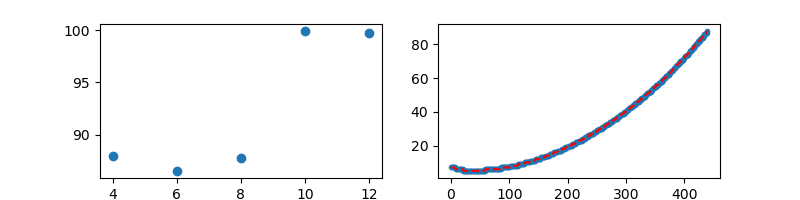

In [35]:
# fit with variable accurate interpolation level
out = np.zeros((0,1), dtype=float)
span = np.arange(4,14,2)
for hh in span:
#    cs = sci.interpolate.splrep(xx_new, yy_new, w= np.append(np.diff(yy_new),np.diff(yy_new[-2:])), k=3,s=hh)
    cs = sci.interpolate.splrep(xx_new, yy_new, k=3,s=hh) 
# Given the knots and coefficients of a cubic B-spline compute
# all derivatives up to order k at a point (or set of points)
    yder = sci.interpolate.spalde(xx_new[0], cs)
    out = np.append(out, np.arctan(yder[1])*360/(2*np.pi))

if rotate == 1:
    out = -1*(out - 90)

plt.close()
fig3, (ax31, ax32) =plt.subplots(1,2, figsize=(8,2))
ax31.plot(span, out, 'o')
ax32.plot(xx_new, yy_new, '.')
ax32.plot(xx_new, sci.interpolate.splev(xx_new,cs), 'r--')
plt.show()
# reduce the span range (es 10,14,2) to note the overfitting in the graph

In [32]:
cs

(array([  0.,   0.,   0.,   0., 439., 439., 439., 439.]),
 array([ 5.94935098,  1.17299618, 27.4891232 , 87.36852275,  0.        ,
         0.        ,  0.        ,  0.        ]),
 3)

In [33]:
yder

array([ 5.94935098e+00, -3.26402378e-02,  9.68004996e-04,  1.75224024e-07])

In [37]:
junk=np.array([[0,0,0,0,0],[0,0,1,0,0],[0,1,0,1,0],[1,0,0,0,1]])
junk

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [1, 0, 0, 0, 1]])

In [40]:
nonzerojunk=np.array(np.nonzero(junk))
nonzerojunk

array([[1, 2, 2, 3, 3],
       [2, 1, 3, 0, 4]])